In [1]:
from modules.settings import global_mmf_settings as gset
from data_preprocess import preprocess_planck_data_esz_cat as ppd
from modules.simulate.spatial_template import sz_pressure_profile as szp
from simulate import cluster_templates as cltemp
from flat_sky_codes import flat_sky_analysis as fsa
from filters import modular_multi_matched_filter as mmf
from masking import gen_masks as gm
from data_preprocess import get_tangent_planes as gtp
from flat_sky_codes import tangent_plane_analysis as tpa
from simulate.spatial_template import sim_cluster as sc
from cosmology import cosmo_fn
import numpy as np
import bces.bces as bces
from astropy.io import fits
import os
from scipy.optimize import curve_fit
%pylab notebook

# def return_log_err(gauss_mean,gauss_err,num_samples=20000):
#     logerr=np.zeros_like(gauss_mean)
#     for idx, mu in enumerate(gauss_mean):
#         x=np.random.normal(mu,gauss_err[idx],num_samples)
#         logerr[idx]=np.std(log10(x))
#     return logerr

def return_log_err(gauss_mean,gauss_err,num_samples=20000,ignore_negatives=True):
    logerr=np.zeros_like(gauss_mean)
    for idx, mu in enumerate(gauss_mean):
        x=np.random.normal(mu,gauss_err[idx],num_samples)
        if ignore_negatives:
            while np.any(x<0):
                neg_idx=np.where(x<0)[0]
                x[neg_idx]=np.random.normal(mu,gauss_err[idx],np.size(neg_idx))
        logerr[idx]=np.std(log10(x))
    return logerr

Populating the interactive namespace from numpy and matplotlib


In [ ]:
cltemp.sc.

In [2]:
outpath="/Users/adityarotti/Documents/Work/Projects/Relativistic-SZ/MMF-filters-for-rSZ-cluster-detection/Planck_MMF/results/planck_esz/"
gset.setup_mmf_config(outpath=outpath,chmin=100.,xsize=10.,result_midfix="random_thet500")
figpath=gset.mmfset.paths["result_figs"]
xsz_cat=ppd.get_tangent_plane_fnames()
#ppd.extract_tangent_planes()
conv_Y5R500_SPHR500=szp.convert_Ycyl_xR500_Ysph_xR500()

In [20]:
tmplt=cltemp.cluster_spectro_spatial_templates(T_min=0.,T_max=1.,T_step=1.,theta500_min=2.,theta500_max=3.,theta_step=1.)
tmplt.setup_templates()
op=mmf.multi_matched_filter(tmplt.sp_ft_bank,tmplt.sz_spec_bank,tmplt.chfiltr,tmplt.fn_yerr_norm)

In [42]:
ints_sample = fits.open(gset.mmfset.union_cat_file)
keys_ints=ints_sample['PSZ2_UNION'].header.keys()
fkeys_ints=[k for k in keys_ints if "TTYPE" in k]
fields_ints=[ints_sample['PSZ2_UNION'].header[tkeys] for tkeys in fkeys_ints]
ints_raw={}
for n in fields_ints:
    if n=="NAME":
        ints_raw[n]=list(ints_sample['PSZ2_UNION'].data.field(n).flatten())
    else:
        ints_raw[n]=ints_sample['PSZ2_UNION'].data.field(n).flatten()

In [44]:
xsz_cat["est_Y500_T0"]=np.zeros(np.size(xsz_cat["YSZ_500"]),float)
xsz_cat["est_Y500_err_T0"]=np.zeros(np.size(xsz_cat["YSZ_500"]),float)
xsz_cat["est_Y500_TT"]=np.zeros(np.size(xsz_cat["YSZ_500"]),float)
xsz_cat["est_Y500_err_TT"]=np.zeros(np.size(xsz_cat["YSZ_500"]),float)

cmask=gm.return_center_mask()
emask=gm.return_edge_apodized_mask(15.,20.)
for idx,filename in enumerate(xsz_cat["FILENAME"]):
    #theta500=xsz_cat["theta500"][idx]
    theta500=xsz_cat["theta500"][idx]
    T500=xsz_cat["T500"][idx]
    glon=xsz_cat["GLON"][idx]
    glat=xsz_cat["GLAT"][idx]
    redshift=xsz_cat["z"][idx]
    #print theta500,T500,glon,glat

    projop=tpa.tangent_plane_setup(gset.mmfset.nside,gset.mmfset.xsize,glat,glon,rescale=1.)
    ix,iy=projop.ang2ij(glon,glat)

    data=gtp.return_data(filename)
    ps_mask=gtp.return_ps_mask(filename)
    
    template=tmplt.gen_template(thetac=theta500)
    template_ft=fsa.map2alm(np.fft.fftshift(template),gset.mmfset.reso)

    temp=tmplt.sz_op.bp_fn_sz_2d_T(0,gset.mmfset.channels)[:,0]
    szspec={}
    for i,ch in enumerate(gset.mmfset.channels):
        szspec[ch]=temp[i]

    temp=tmplt.sz_op.bp_fn_sz_2d_T(T500,gset.mmfset.channels)[:,0]
    szspecT={}
    for i,ch in enumerate(gset.mmfset.channels):
        szspecT[ch]=temp[i]
        
    op.get_data_ft(data*ps_mask*emask,smwin=5)
    fdata,err=op.evaluate_mmf(template_ft,szspec)
    yc=max((fdata*cmask).ravel())
    cluster=sc.gen_field_cluster_template(ix,iy,theta500,npix=gset.mmfset.npix,pixel_size=gset.mmfset.reso,y0=yc,cutoff=5.)
    Y500_T0=np.sum(cluster)*(gset.mmfset.reso**2.)*conv_Y5R500_SPHR500*((cosmo_fn.dA(redshift)*(np.pi/180./60.))**2.)
    Y500_err_T0=err*Y500_T0/yc
    xsz_cat["est_Y500_T0"][idx]=Y500_T0
    xsz_cat["est_Y500_err_T0"][idx]=Y500_err_T0
    
    #op.get_data_ft(data*ps_mask*emask,smwin=5)
    fdata,err=op.evaluate_mmf(template_ft,szspecT)
    #yc=fdata[ix,iy]
    yc=max((fdata*cmask).ravel())
    cluster=sc.gen_field_cluster_template(ix,iy,theta500,npix=gset.mmfset.npix,pixel_size=gset.mmfset.reso,y0=yc,cutoff=5.)
    Y500_TT=np.sum(cluster)*(gset.mmfset.reso**2.)*conv_Y5R500_SPHR500*((cosmo_fn.dA(redshift)*(np.pi/180./60.))**2.)
    Y500_err_TT=err*Y500_TT/yc
    xsz_cat["est_Y500_TT"][idx]=Y500_TT
    xsz_cat["est_Y500_err_TT"][idx]=Y500_err_TT
    
    print xsz_cat["YSZ_500"][idx],xsz_cat["YSZ_500_err"][idx],Y500_T0/Y500_err_T0,Y500_TT/Y500_err_TT
    
hdu0=fits.PrimaryHDU()
hdu_list=[]
hdu_list=append(hdu_list,hdu0)
filename=gset.mmfset.paths["result_data"] + "xsz_cat_" + str(gset.mmfset.xsize) + "deg.fits"
for key in xsz_cat.keys():
    if key!="FILENAME":
        temp_hdu = fits.ImageHDU()
        temp_hdu.header["EXTNAME"]=key
        temp_hdu.data=xsz_cat[key]
        hdu_list=append(hdu_list,temp_hdu)
hdu=fits.HDUList([hdu for hdu in hdu_list])

hdu.writeto(filename,overwrite=True)    

0.000174 2.1e-05 13.6157901977 13.7329238464
4.7e-05 5e-06 18.8642864034 18.8696321171
0.00014 1.7e-05 10.5049984037 10.5577788416
2.7e-05 3e-06 12.5334166814 12.5540099612
8.6e-05 1.3e-05 11.3166873808 11.2732291818
8.3e-05 8e-06 15.0577191192 15.0796969105
0.000109 1.3e-05 13.0912382987 13.132303716
1.8e-05 3e-06 9.82045202495 9.82710905352
3.5e-05 3e-06 17.7614538332 17.7756517681
9.2e-05 8e-06 15.428936222 15.5013753469
9e-05 7e-06 28.6235471148 28.6299376752
9.9e-05 1.4e-05 11.4177809623 11.4049438085
0.000129 1e-05 20.7567004466 20.7252992942
0.000118 1.3e-05 11.3815453648 11.395361328
9.7e-05 1.3e-05 12.0315123647 12.0850773487
4.5e-05 7e-06 9.38214379344 9.37460249538
1e-05 2e-06 10.3193173996 10.3438897911
4.7e-05 6e-06 13.0694768267 13.0373569161
0.000109 7e-06 20.9333561059 20.9525529957
0.000266 1.4e-05 25.3897079512 25.6584439989
0.000109 1.1e-05 15.6768810117 15.6598202991
8.6e-05 5e-06 24.7300702344 24.7349233053
8.6e-05 1.1e-05 12.2681266646 12.2747714859
7.2e-05 1.4e-0

In [ ]:
0.000174 2.1e-05 13.6157901977 13.7329238464
4.7e-05 5e-06 18.8642864034 18.8696321171
0.00014 1.7e-05 10.5049984037 10.5577788416

In [24]:
# filename=gset.mmfset.paths["result_data"] + "xsz_cat_" + str(gset.mmfset.xsize) + "deg.fits"
# f1=fits.open(filename)
# xsz_cat={}
# for i in range(len(f1)-1):
#     key=f1[i+1].header["EXTNAME"]
#     xsz_cat[key]=f1[i+1].data
    
# for idx in range(len(xsz_cat["z"])):
#     print xsz_cat["YSZ_500"][idx],xsz_cat["YSZ_500_err"][idx],xsz_cat["est_Y500_T0"][idx],xsz_cat["est_Y500_err_T0"][idx],xsz_cat["est_Y500_TT"][idx],xsz_cat["est_Y500_err_TT"][idx]

<IPython.core.display.Javascript object>


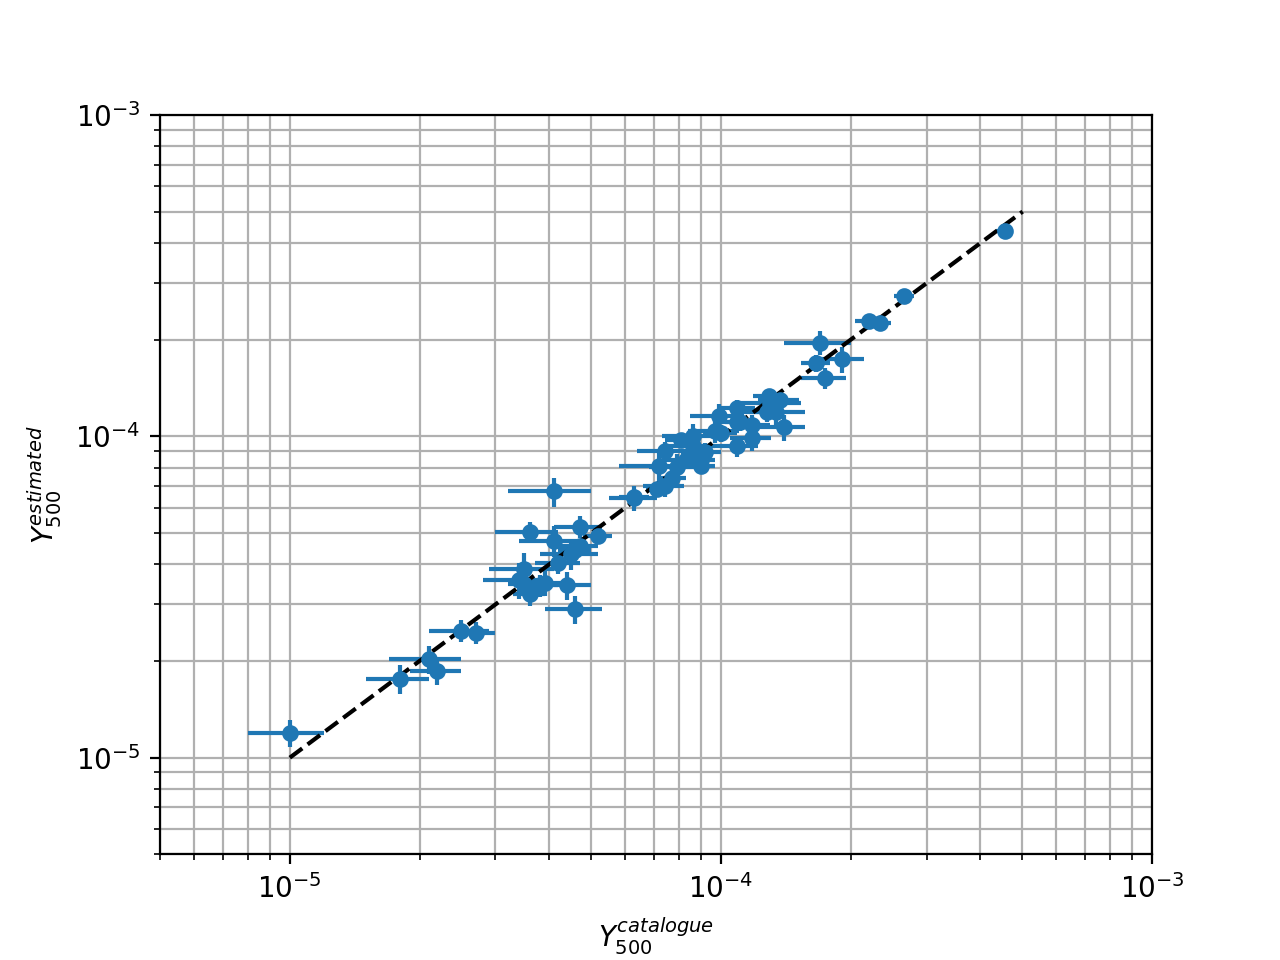

In [45]:
x=logspace(-5,-3.3,100)
figure()
errorbar(xsz_cat["YSZ_500"],xsz_cat["est_Y500_T0"],xerr=xsz_cat["YSZ_500_err"],yerr=xsz_cat["est_Y500_err_T0"],fmt='o',ms=5,label="Catalogue")
plot(x,x,"k--")
grid(which="both")
xlabel("$Y^{catalogue}_{500}$",fontsize=10)
ylabel("$Y^{estimated}_{500}$",fontsize=10)
loglog()
ylim(5e-6,1e-3)
xlim(5e-6,1e-3)
figname=figpath + "compare_Y500.pdf"
savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


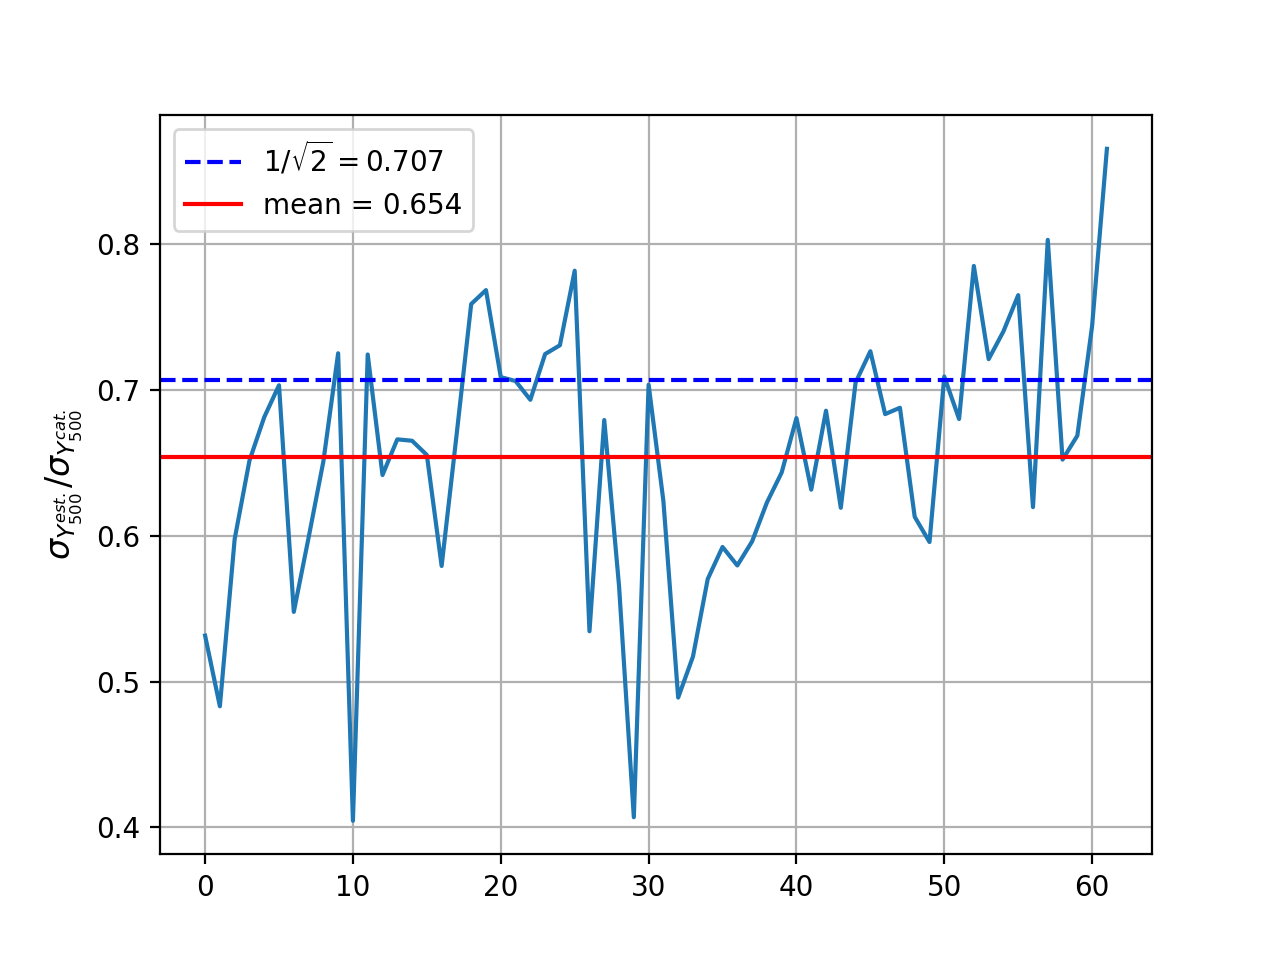

In [46]:
figure()
plot(xsz_cat["est_Y500_err_T0"]/xsz_cat["YSZ_500_err"])
#axhline(1,ls="--",c="k")
axhline(1/1.414,ls="--",c="b",label="$1/\sqrt{2}=$" + str(round(1/sqrt(2.),3)))
mu=mean(np.array(xsz_cat["est_Y500_err_T0"])/np.array(xsz_cat["YSZ_500_err"]))
axhline(mu,label="mean = "+ str(round(mu,3)),c="r")
legend(loc=0)
ylabel("$\sigma_{Y^{est.}_{500}}/\sigma_{Y^{cat.}_{500}}$",fontsize=12)
grid()
figname=figpath + "compare_Y500_err.pdf"
savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


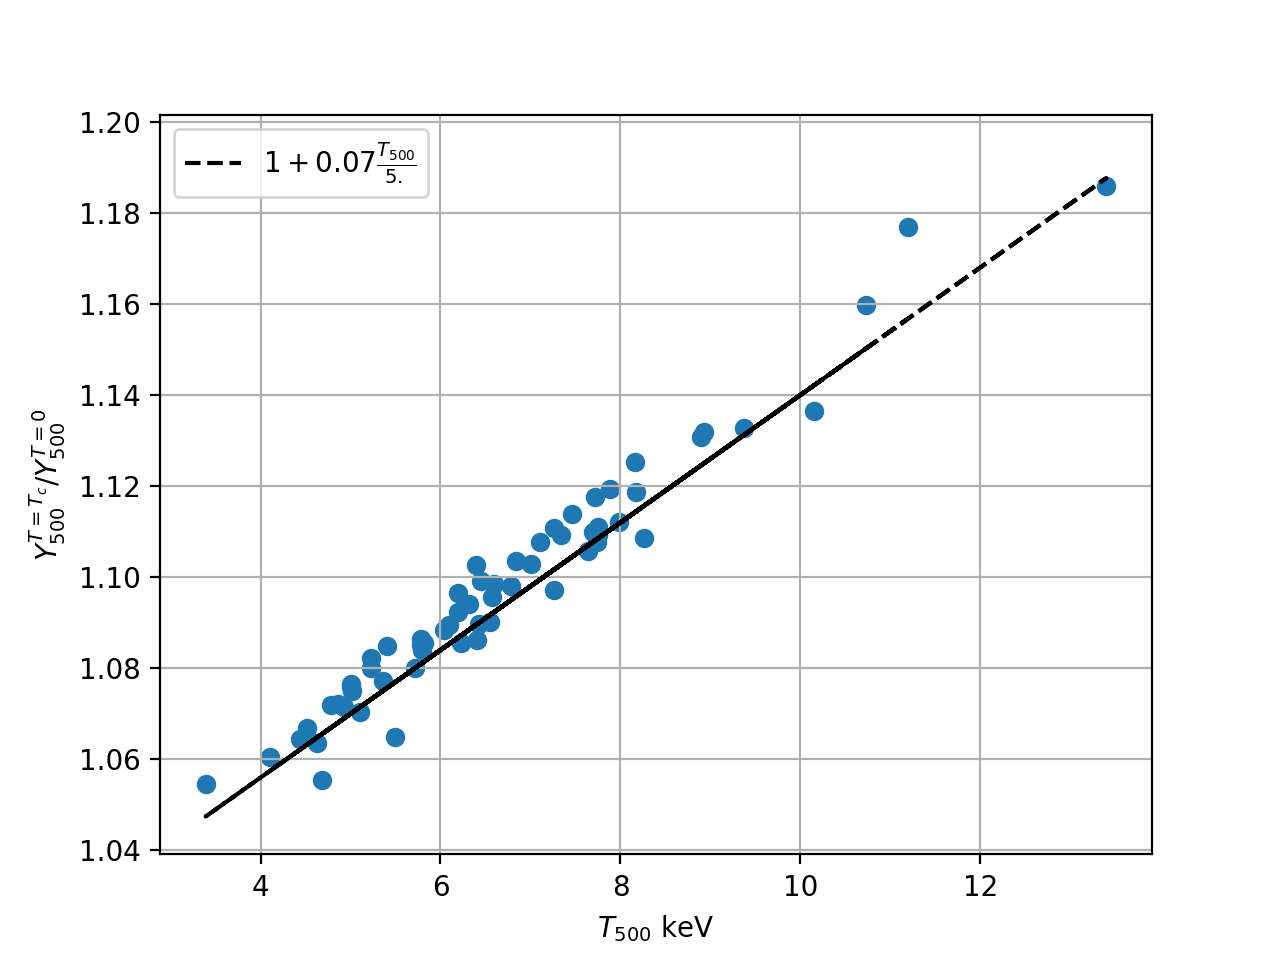

In [47]:
figure()
scatter(xsz_cat["T500"],xsz_cat["est_Y500_TT"]/xsz_cat["est_Y500_T0"])
plot(xsz_cat["T500"],1+0.07*xsz_cat["T500"]/5.,"k--",label=r"$1 + 0.07 \frac{T_{500}}{5.}$")
xlabel('$T_{500}$ keV')
ylabel('$Y^{T=T_c}_{500}/Y^{T=0}_{500}$')
grid()
legend(loc=0)
figname=figpath + "Y500_T0_vs_Y500_Tc.pdf"
savefig(figname,bbox_inches="tight")

In [48]:
# Catalogue
xdata=log10(xsz_cat["YX_500"]/1e-4)
xerr=return_log_err(xsz_cat["YX_500"]/1e-4,xsz_cat["YX_500_err"]/1e-4)
ydata=log10(xsz_cat["YSZ_500"])
yerr=return_log_err(xsz_cat["YSZ_500"],xsz_cat["YSZ_500_err"])

acat,bcat,erracat,errbcat,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),100000)
# print acat
# print erracat
# print bcat
# print errbcat


# T=0
xdata=log10(xsz_cat["YX_500"]/1e-4)
xerr=return_log_err(xsz_cat["YX_500"]/1e-4,xsz_cat["YX_500_err"]/1e-4)
ydata=log10(xsz_cat["est_Y500_T0"])
yerr=return_log_err(xsz_cat["est_Y500_T0"],xsz_cat["est_Y500_err_T0"])

aT0,bT0,erraT0,errbT0,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),100000)
# print aT0
# print erraT0
# print bT0
# print errbT0

# T=T_c
xdata=log10(xsz_cat["YX_500"]/1e-4)
xerr=return_log_err(xsz_cat["YX_500"]/1e-4,xsz_cat["YX_500_err"]/1e-4)
ydata=log10(xsz_cat["est_Y500_TT"])
yerr=return_log_err(xsz_cat["est_Y500_TT"],xsz_cat["est_Y500_err_TT"])

aTT,bTT,erraTT,errbTT,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),100000)
# print aTT
# print erraTT
# print bTT
# print errbTT

BCES, 100000 trials... 
12.686011 s
BCES, 100000 trials... 
12.526426 s
BCES, 100000 trials... 
12.695971 s


<IPython.core.display.Javascript object>


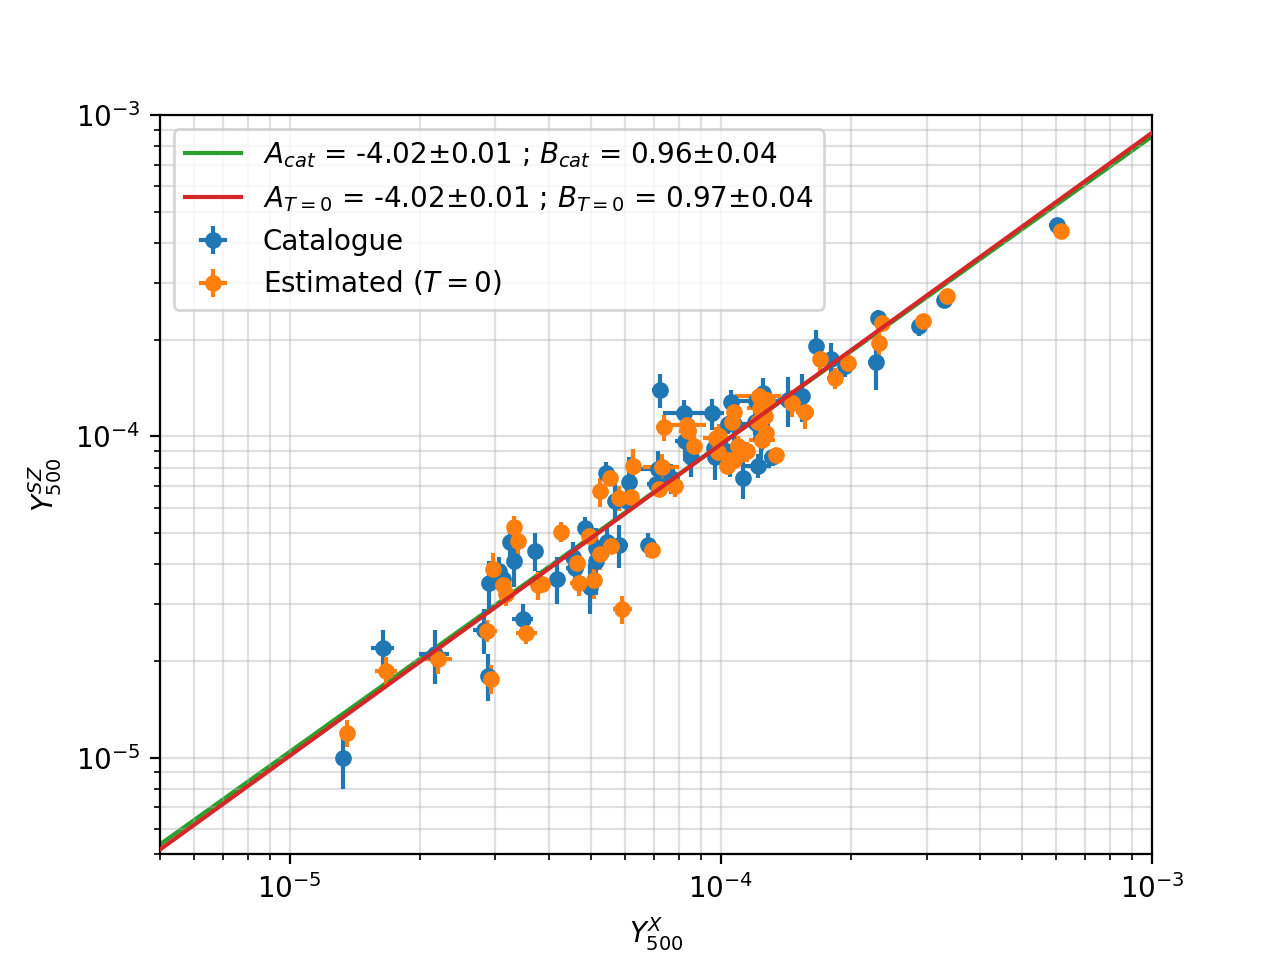

In [49]:
figure()
errorbar(xsz_cat["YX_500"],xsz_cat["YSZ_500"],xerr=xsz_cat["YX_500_err"],yerr=xsz_cat["YSZ_500_err"],fmt='o',ms=5,label="Catalogue")
errorbar(xsz_cat["YX_500"]+0.02*xsz_cat["YX_500"],xsz_cat["est_Y500_T0"],xerr=xsz_cat["YX_500_err"],yerr=xsz_cat["est_Y500_err_T0"],fmt='o',ms=5,label="Estimated $(T=0)$")
tempx=linspace(5e-6,5e-3,1000)
lbl="$A_{cat}$ = " + str(round(bcat[3],2)) + "$\pm$" + str(round(errbcat[3],2)) 
lbl=lbl + " ; $B_{cat}$ = " +str(round(acat[3],2))  + "$\pm$" + str(round(erracat[3],2))
plot(tempx,(10.**bcat[3])*(tempx/1e-4)**acat[3],label=lbl,zorder=1)

lbl="$A_{T=0}$ = " + str(round(bT0[3],2)) + "$\pm$" + str(round(errbT0[3],2)) 
lbl=lbl + " ; $B_{T=0}$ = " +str(round(aT0[3],2))  + "$\pm$" + str(round(erraT0[3],2))
plot(tempx,(10.**bT0[3])*(tempx/1e-4)**aT0[3],label=lbl,zorder=3)
ylim(5e-6,1e-3)
xlim(5e-6,1e-3)
loglog()
legend(loc=0)
ylabel("$Y^{SZ}_{500}$",fontsize=10)
xlabel("$Y^X_{500}$",fontsize=10)
grid(which="both",alpha=0.4)
figname=figpath + "YSZ500_YX500_cat_vs_est.pdf"
savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


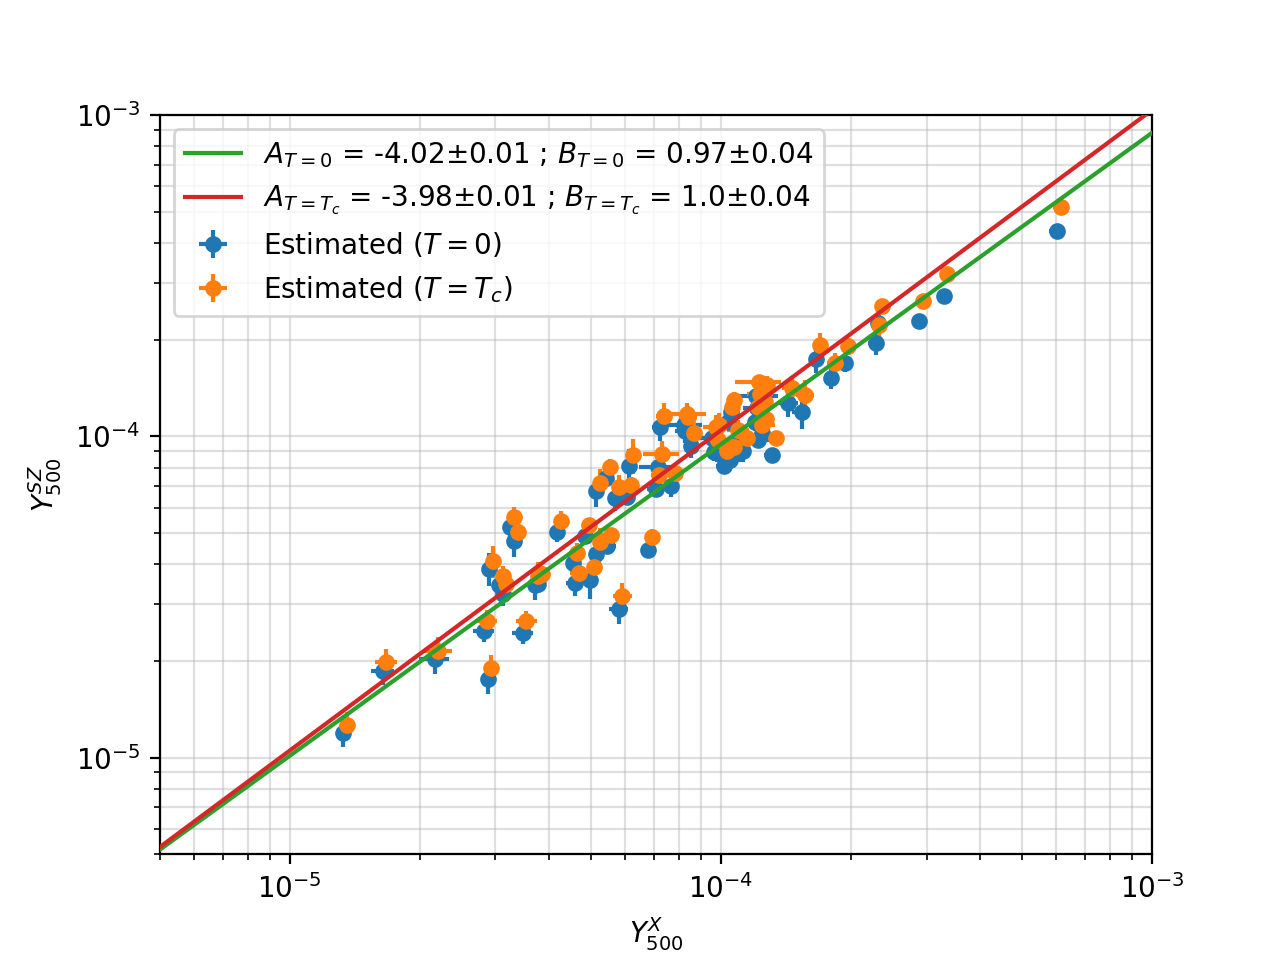

In [50]:
figure()
errorbar(xsz_cat["YX_500"],xsz_cat["est_Y500_T0"],xerr=xsz_cat["YX_500_err"],yerr=xsz_cat["est_Y500_err_T0"],fmt='o',ms=5,label="Estimated $(T=0)$")
errorbar(xsz_cat["YX_500"]+0.02*xsz_cat["YX_500"],xsz_cat["est_Y500_TT"],xerr=xsz_cat["YX_500_err"],yerr=xsz_cat["est_Y500_err_TT"],fmt='o',ms=5,label="Estimated $(T=T_c)$")
tempx=linspace(5e-6,5e-3,1000)
lbl="$A_{T=0}$ = " + str(round(bT0[3],2)) + "$\pm$" + str(round(errbT0[3],2)) 
lbl=lbl + " ; $B_{T=0}$ = " +str(round(aT0[3],2))  + "$\pm$" + str(round(erraT0[3],2))
plot(tempx,(10.**bT0[3])*(tempx/1e-4)**aT0[3],label=lbl,zorder=3)


lbl="$A_{T=T_c}$ = " + str(round(bTT[3],2)) + "$\pm$" + str(round(errbTT[3],2)) 
lbl=lbl + " ; $B_{T=T_c}$ = " +str(round(aTT[3],2))  + "$\pm$" + str(round(erraTT[3],2))
plot(tempx,(10.**bTT[3])*(tempx/1e-4)**aTT[3],label=lbl,zorder=5)

# lbl="$A_{cat}$ = " + str(round(bcat[3],2)) + "$\pm$" + str(round(errbcat[3],2)) 
# lbl=lbl + " ; $B_{cat}$ = " +str(round(acat[3],2))  + "$\pm$" + str(round(erracat[3],2))
# plot(tempx,(10.**bcat[3])*(tempx/1e-4)**acat[3],"k-",label=lbl)

ylim(5e-6,1e-3)
xlim(5e-6,1e-3)
loglog()
legend(loc=0)
ylabel("$Y^{SZ}_{500}$",fontsize=10)
xlabel("$Y^X_{500}$",fontsize=10)
grid(which="both",alpha=0.4)
figname=figpath + "YSZ500_YX500_T0_vs_TT.pdf"
savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


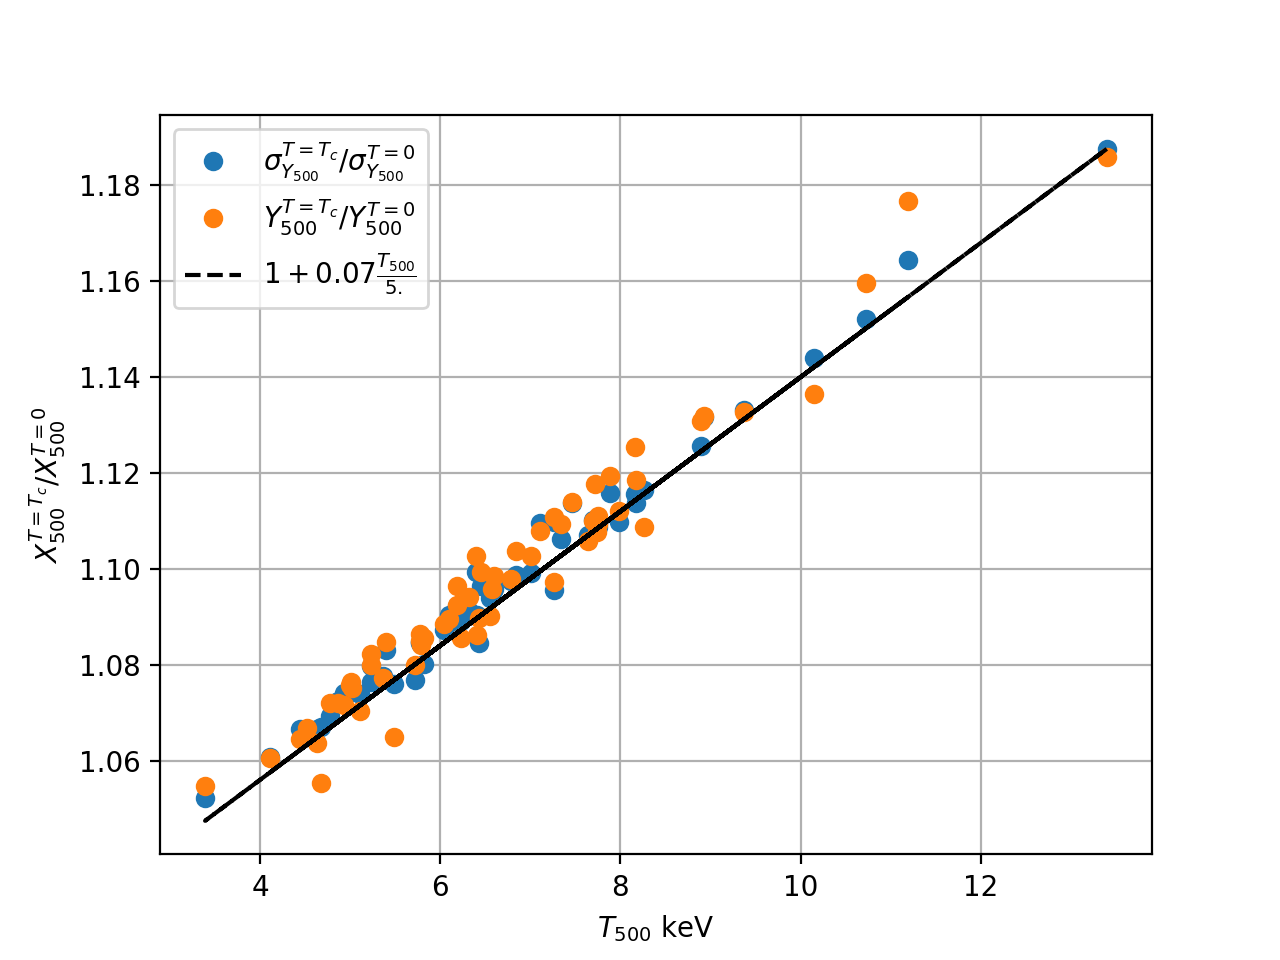

In [51]:
figure()
plot(xsz_cat["T500"],xsz_cat["est_Y500_err_TT"]/xsz_cat["est_Y500_err_T0"],"o",label="$\sigma^{T=T_c}_{Y_{500}}/\sigma^{T=0}_{Y_{500}}$")
plot(xsz_cat["T500"],xsz_cat["est_Y500_TT"]/xsz_cat["est_Y500_T0"],"o",label="$Y^{T=T_c}_{500}/Y^{T=0}_{500}$")
plot(xsz_cat["T500"],1+0.07*xsz_cat["T500"]/5.,"k--",label=r"$1 + 0.07 \frac{T_{500}}{5.}$")
xlabel('$T_{500}$ keV')
ylabel('$X^{T=T_c}_{500}/X^{T=0}_{500}$')
grid()
legend(loc=0)
figname=figpath + "Y500_vs_Y500_err.pdf"
savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


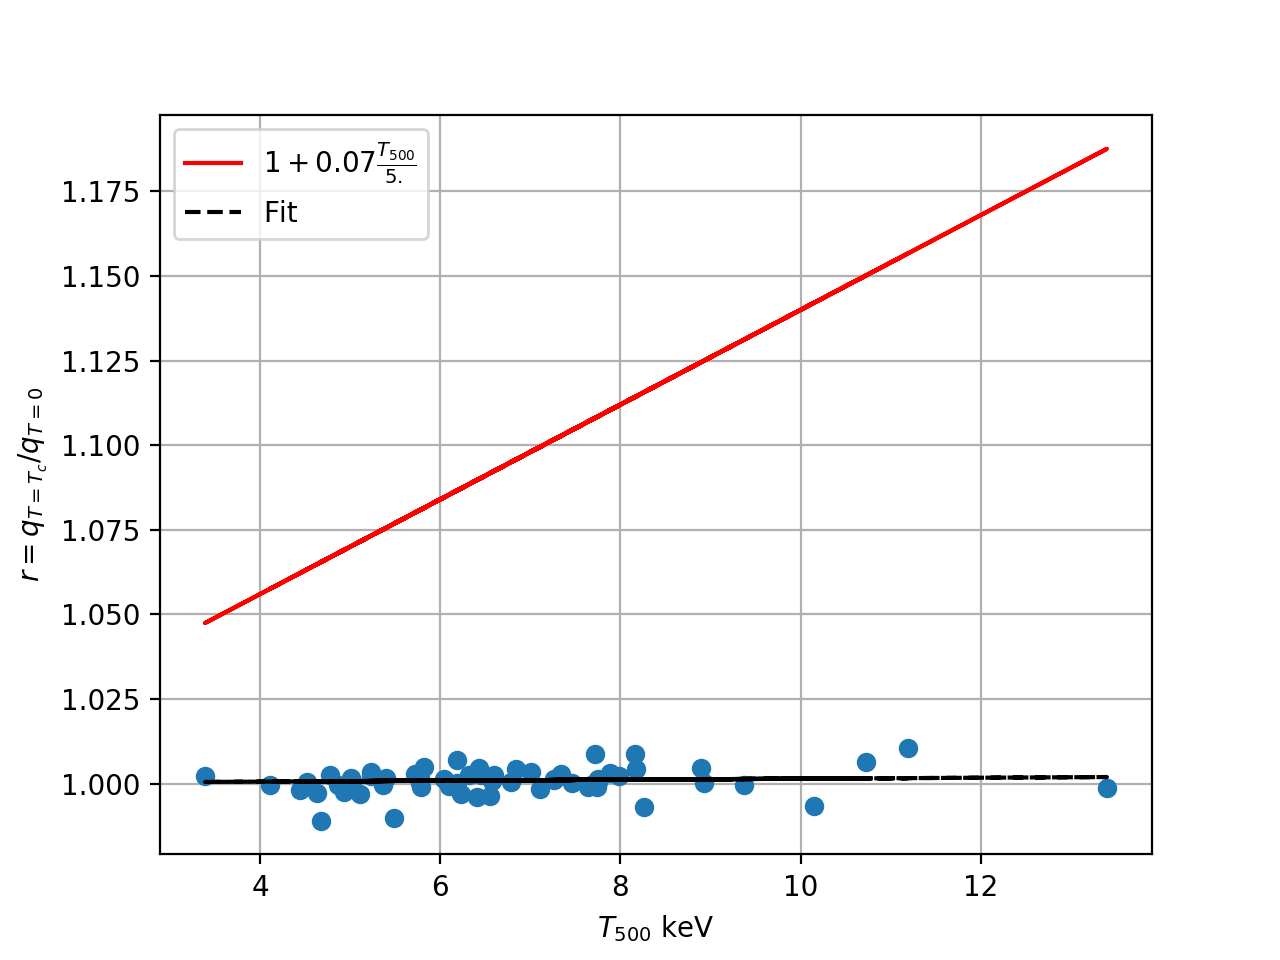

In [52]:
qT0=xsz_cat["est_Y500_T0"]/xsz_cat["est_Y500_err_T0"]
qTT=xsz_cat["est_Y500_TT"]/xsz_cat["est_Y500_err_TT"]

fn=lambda x,a: 1.+a*x/5.
slope,slope_err=curve_fit(fn,xsz_cat["T500"],qTT/qT0)

figure()
plot(xsz_cat["T500"],qTT/qT0,"o")
plot(xsz_cat["T500"],1+0.07*xsz_cat["T500"]/5.,"r-",label=r"$1 + 0.07 \frac{T_{500}}{5.}$")
plot(xsz_cat["T500"],fn(xsz_cat["T500"],slope),"k--",label="Fit")
xlabel('$T_{500}$ keV')
ylabel('$r=q_{T=T_c}/q_{T=0}$')
grid()
legend(loc=0)
figname=figpath + "SNR_qT0_qTT.pdf"
savefig(figname,bbox_inches="tight")

In [53]:
xsz_cat["ints_z"]=np.zeros(np.size(xsz_cat["YSZ_500"]),float)
xsz_cat["ints_YSZ_500"]=np.zeros(np.size(xsz_cat["YSZ_500"]),float)
xsz_cat["ints_YSZ_500_err"]=np.zeros(np.size(xsz_cat["YSZ_500"]),float)
xsz_cat["ints_snr"]=np.zeros(np.size(xsz_cat["YSZ_500"]),float)
xsz_cat["ints_cosmo"]=np.zeros(np.size(xsz_cat["YSZ_500"]),float)

thr=0.2
for idx, glon in enumerate(xsz_cat["GLON"]):
    glat=xsz_cat["GLAT"][idx]
    for jdx, ints_glon in enumerate(ints_raw["GLON"]):
        ints_glat=ints_raw["GLAT"][jdx]
        if (abs(ints_glat-glat)<thr) & (abs(ints_glon-glon)<thr):
            xsz_cat["ints_z"][idx]=ints_raw["REDSHIFT"][jdx]
            xsz_cat["ints_YSZ_500"][idx]=ints_raw["Y5R500"][jdx]
            xsz_cat["ints_YSZ_500_err"][idx]=ints_raw["Y5R500_ERR"][jdx]
            xsz_cat["ints_snr"][idx]=ints_raw["SNR"][jdx]
            xsz_cat["ints_cosmo"][idx]=ints_raw["COSMO"][jdx]
            #print idx,jdx,glon,ints_glon,glat,ints_glat,xsz_cat["ints_z"][idx],xsz_cat["z"][idx]
            
xsz_cat["ints_YSZ_500"]=(cosmo_fn.dA(xsz_cat["ints_z"])**2.)*xsz_cat["ints_YSZ_500"]*(10**(-3.))*((np.pi/180./60.)**2.)*cosmo_fn.conv_y2y500
xsz_cat["ints_YSZ_500_err"]=(cosmo_fn.dA(xsz_cat["ints_z"])**2.)*xsz_cat["ints_YSZ_500_err"]*(10**(-3.))*((np.pi/180./60.)**2.)*cosmo_fn.conv_y2y500

<IPython.core.display.Javascript object>


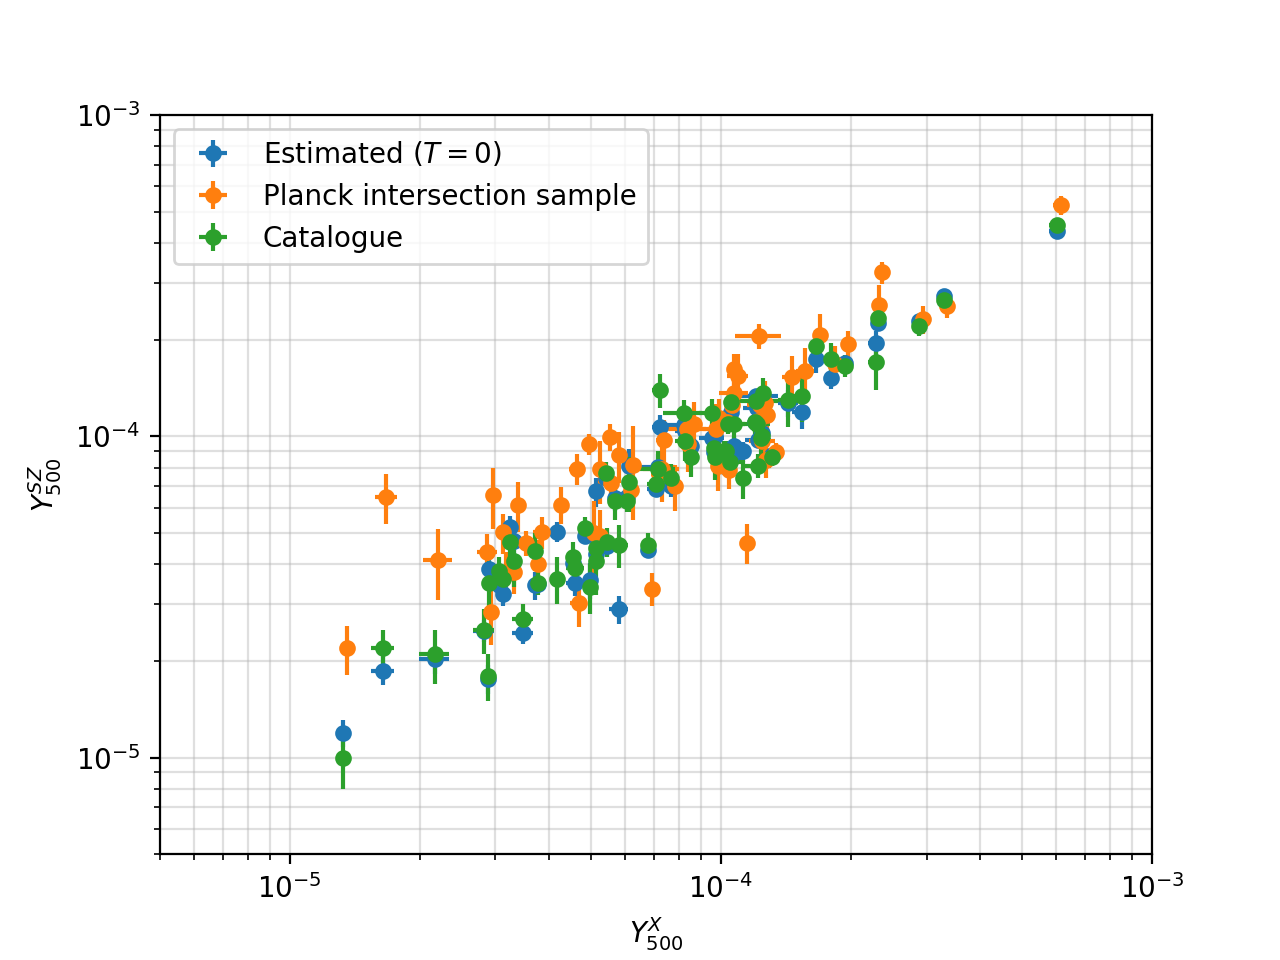

In [54]:
figure()
errorbar(xsz_cat["YX_500"],xsz_cat["est_Y500_T0"],xerr=xsz_cat["YX_500_err"],yerr=xsz_cat["est_Y500_err_T0"],fmt='o',ms=5,label="Estimated $(T=0)$")
errorbar(xsz_cat["YX_500"]+0.02*xsz_cat["YX_500"],xsz_cat["ints_YSZ_500"],xerr=xsz_cat["YX_500_err"],yerr=xsz_cat["ints_YSZ_500_err"],fmt='o',ms=5,label="Planck intersection sample")
errorbar(xsz_cat["YX_500"],xsz_cat["YSZ_500"],xerr=xsz_cat["YX_500_err"],yerr=xsz_cat["YSZ_500_err"],fmt='o',ms=5,label="Catalogue")
ylim(5e-6,1e-3)
xlim(5e-6,1e-3)
loglog()
legend(loc=0)
ylabel("$Y^{SZ}_{500}$",fontsize=10)
xlabel("$Y^X_{500}$",fontsize=10)
grid(which="both",alpha=0.4)
figname=figpath + "Y500_vs_YX500_comparison_with_planck_estimates.pdf"
savefig(figname,bbox_inches="tight")

# Y_500 & M_500 fitted relations

# Fitting $D^2_A(z)Y_{500} - M_{500}$ as in Planck early results XI

In [55]:
# # This produces numbers in row 2 of Table 2 from Planck early results XI (A&A 536 A11 2011)
# Ezgamma=cosmo_fn.Ez(xsz_cat["z"])**(-2./3.)
# This produces numbers in Table A.1 from Planck Collaboration: Cosmology from SZ cluster counts (2013)
Ezgamma=cosmo_fn.Ez(xsz_cat["z"])**(-2./3.)/1e-4

# Catalogue
xdata=log10(xsz_cat["M500"]/6.)
xerr=return_log_err(xsz_cat["M500"]/6.,xsz_cat["M500_err"]/6.)

ydata=log10(xsz_cat["YSZ_500"]*Ezgamma)
yerr=return_log_err(xsz_cat["YSZ_500"]*Ezgamma,xsz_cat["YSZ_500_err"]*Ezgamma)

acat,bcat,erracat,errbcat,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),100000)
print acat[3],erracat[3],bcat[3],errbcat[3]


# Catalogue
xdata=log10(xsz_cat["M500"]/6.)
xerr=return_log_err(xsz_cat["M500"]/6.,xsz_cat["M500_err"]/6.)
ydata=log10(xsz_cat["est_Y500_T0"]*Ezgamma)
yerr=return_log_err(xsz_cat["est_Y500_T0"]*Ezgamma,xsz_cat["est_Y500_err_T0"]*Ezgamma)

aT0,bT0,erraT0,errbT0,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),100000)
print aT0[3],erraT0[3],bT0[3],errbT0[3]

# Catalogue
xdata=log10(xsz_cat["M500"]/6.)
xerr=return_log_err(xsz_cat["M500"]/6.,xsz_cat["M500_err"]/6.)
ydata=log10(xsz_cat["est_Y500_TT"]*Ezgamma)
yerr=return_log_err(xsz_cat["est_Y500_TT"]*Ezgamma,xsz_cat["est_Y500_err_TT"]*Ezgamma)

aTT,bTT,erraTT,errbTT,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),100000)
print aTT[3],erraTT[3],bTT[3],errbTT[3]

BCES, 100000 trials... 
13.232665 s
1.73561800255 0.0772013366908 -0.188432475523 0.0124755871667
BCES, 100000 trials... 
12.457722 s
1.76928126941 0.0754333150188 -0.1907091628 0.0129514667201
BCES, 100000 trials... 
12.824857 s
1.81726345227 0.0732310037964 -0.151347576284 0.0127582994144


<IPython.core.display.Javascript object>


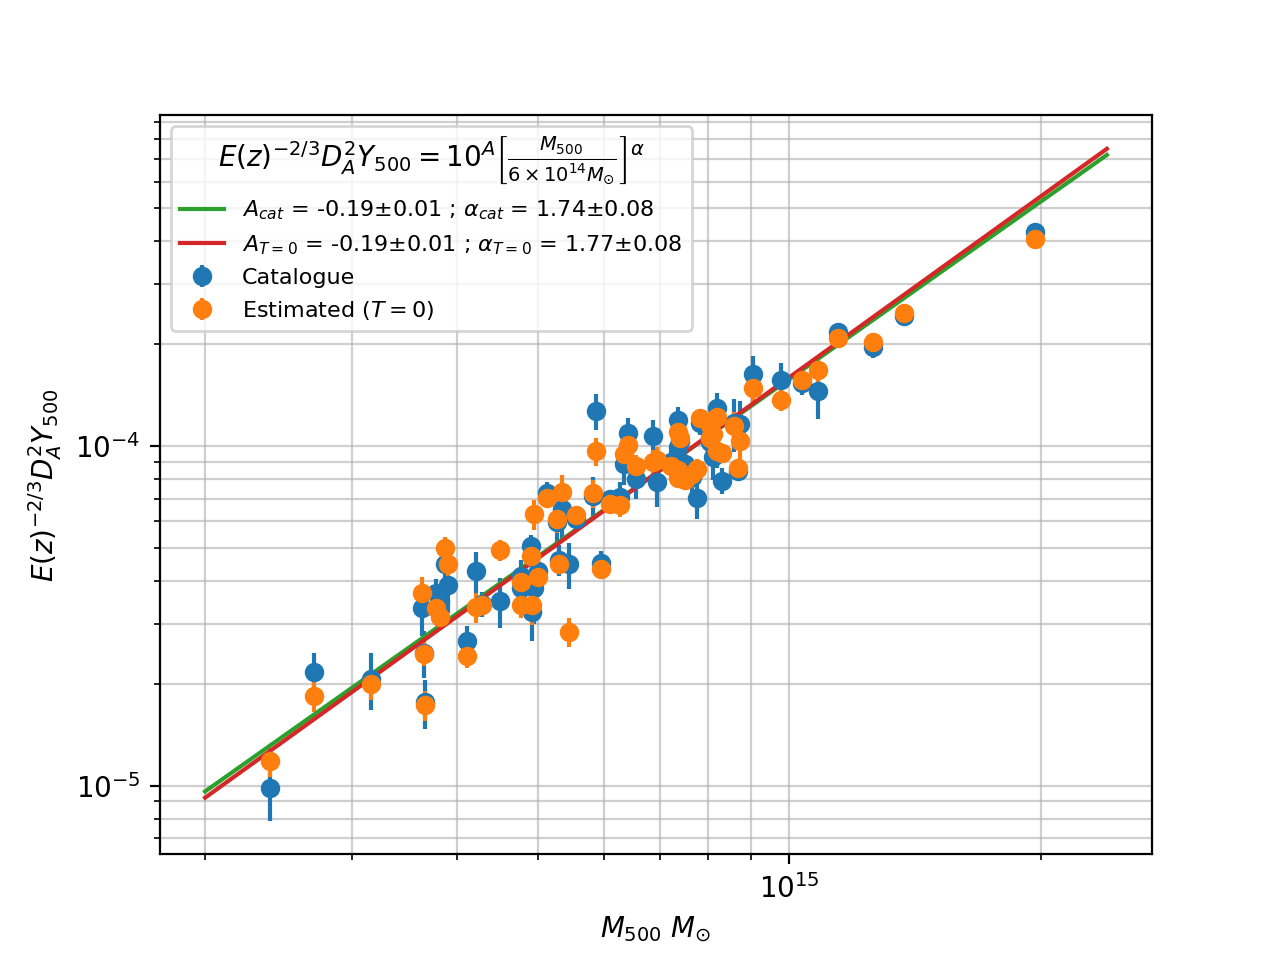

In [56]:
M500=linspace(2,24,1000)
norm=1e-4
figure()
errorbar(xsz_cat["M500"]*1e14,Ezgamma*xsz_cat["YSZ_500"]*norm,yerr=xsz_cat["YSZ_500_err"]*Ezgamma*norm,fmt="o",label="Catalogue")
errorbar(xsz_cat["M500"]*1e14,Ezgamma*xsz_cat["est_Y500_T0"]*norm,yerr=xsz_cat["est_Y500_err_T0"]*Ezgamma*norm,fmt="o",label="Estimated $(T=0)$")
#plot(M500*1e14,(10.**bcat[3])*((M500/6.)**acat[3]))

lbl=r"$A_{cat}$ = " + str(round(bcat[3],2)) + r"$\pm$" + str(round(errbcat[3],2)) 
lbl=lbl + r" ; $\alpha_{cat}$ = " +str(round(acat[3],2))  + r"$\pm$" + str(round(erracat[3],2))
plot(M500*1e14,(10.**bcat[3])*((M500/6.)**acat[3])*norm,label=lbl)

lbl=r"$A_{T=0}$ = " + str(round(bT0[3],2)) + "$\pm$" + str(round(errbT0[3],2)) 
lbl=lbl + r" ; $\alpha_{T=0}$ = " +str(round(aT0[3],2))  + "$\pm$" + str(round(erraT0[3],2))
plot(M500*1e14,(10.**bT0[3])*((M500/6.)**aT0[3])*norm,label=lbl)

ylabel(r"$E(z)^{-2/3} D^2_A Y_{500}$")
xlabel(r"$M_{500}$" + " " + "$M_{\odot}$")
lbl=r"$E(z)^{-2/3} D^2_A Y_{500} = 10^A \left[ \frac{M_{500}}{6 \times 10^{14} M_{\odot}}\right]^\alpha$"
legend(loc=0,title=lbl,fontsize=8)
loglog()
grid(which="both",alpha=0.6)
figname=figpath + "Y500_vs_M500_compare_with_cat.pdf"
savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


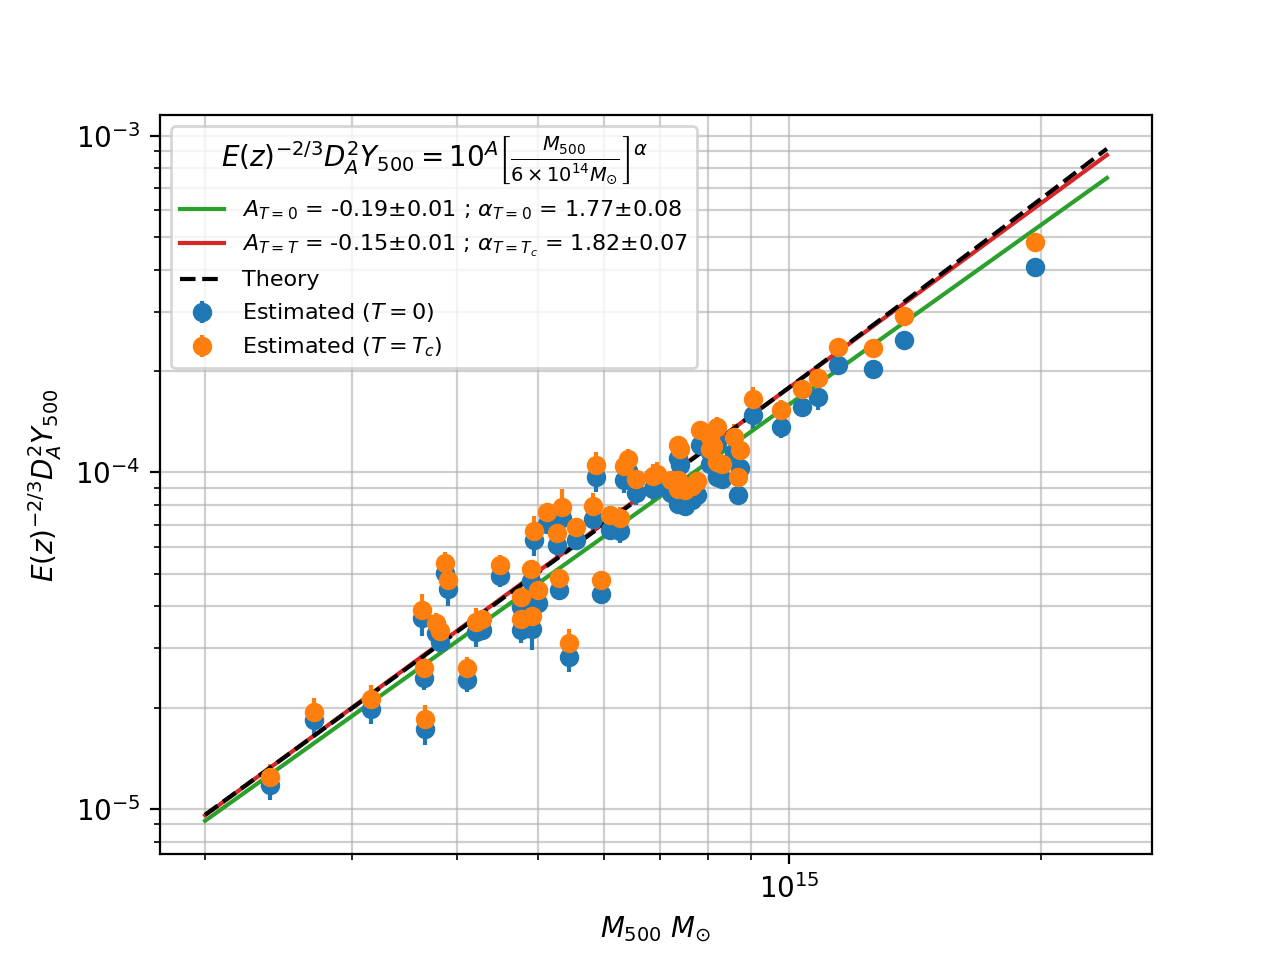

In [57]:
M500=linspace(2,24,1000)
T500=cosmo_fn.convert_M500_T500(M500,0.)
correction=1+0.07*(T500/5.)
norm=1e-4
figure()
errorbar(xsz_cat["M500"]*1e14,Ezgamma*xsz_cat["est_Y500_T0"]*norm,yerr=xsz_cat["est_Y500_err_T0"]*Ezgamma*norm,fmt="o",label="Estimated $(T=0)$")
errorbar(xsz_cat["M500"]*1e14,Ezgamma*xsz_cat["est_Y500_TT"]*norm,yerr=xsz_cat["est_Y500_err_TT"]*Ezgamma*norm,fmt="o",label="Estimated $(T=T_c)$")
#plot(M500*1e14,(10.**bcat[3])*((M500/6.)**acat[3]))

lbl=r"$A_{T=0}$ = " + str(round(bT0[3],2)) + "$\pm$" + str(round(errbT0[3],2)) 
lbl=lbl + r" ; $\alpha_{T=0}$ = " +str(round(aT0[3],2))  + "$\pm$" + str(round(erraT0[3],2))
plot(M500*1e14,(10.**bT0[3])*((M500/6.)**aT0[3])*norm,label=lbl)

lbl=r"$A_{T=T}$ = " + str(round(bTT[3],2)) + r"$\pm$" + str(round(errbTT[3],2)) 
lbl=lbl + r" ; $\alpha_{T=T_c}$ = " +str(round(aTT[3],2))  + r"$\pm$" + str(round(erraTT[3],2))
plot(M500*1e14,(10.**bTT[3])*((M500/6.)**aTT[3])*norm,label=lbl)

plot(M500*1e14,(10.**bT0[3])*((M500/6.)**aT0[3])*norm*correction,"k--",label="Theory")

ylabel(r"$E(z)^{-2/3} D^2_A Y_{500}$")
xlabel(r"$M_{500}$" + " " + "$M_{\odot}$")
lbl=r"$E(z)^{-2/3} D^2_A Y_{500} = 10^A \left[ \frac{M_{500}}{6 \times 10^{14} M_{\odot}}\right]^\alpha$"
legend(loc=0,title=lbl,fontsize=8)
loglog()
grid(which="both",alpha=0.6)
figname=figpath + "Y500_vs_M500_rSZ_correction.pdf"
savefig(figname,bbox_inches="tight")

# Example setup for testing BCES regression

In [185]:
atrue=1.26 ; btrue=3.7
x=linspace(1,100,10)
xerr=np.random.normal(2,0.4,10)
yerr=np.random.normal(2.5,0.4,10)
xdata=linspace(1,100,10) + np.random.normal(0.,xerr)
ydata=linspace(1,100,10)*atrue + np.random.normal(0,yerr) + btrue

<IPython.core.display.Javascript object>


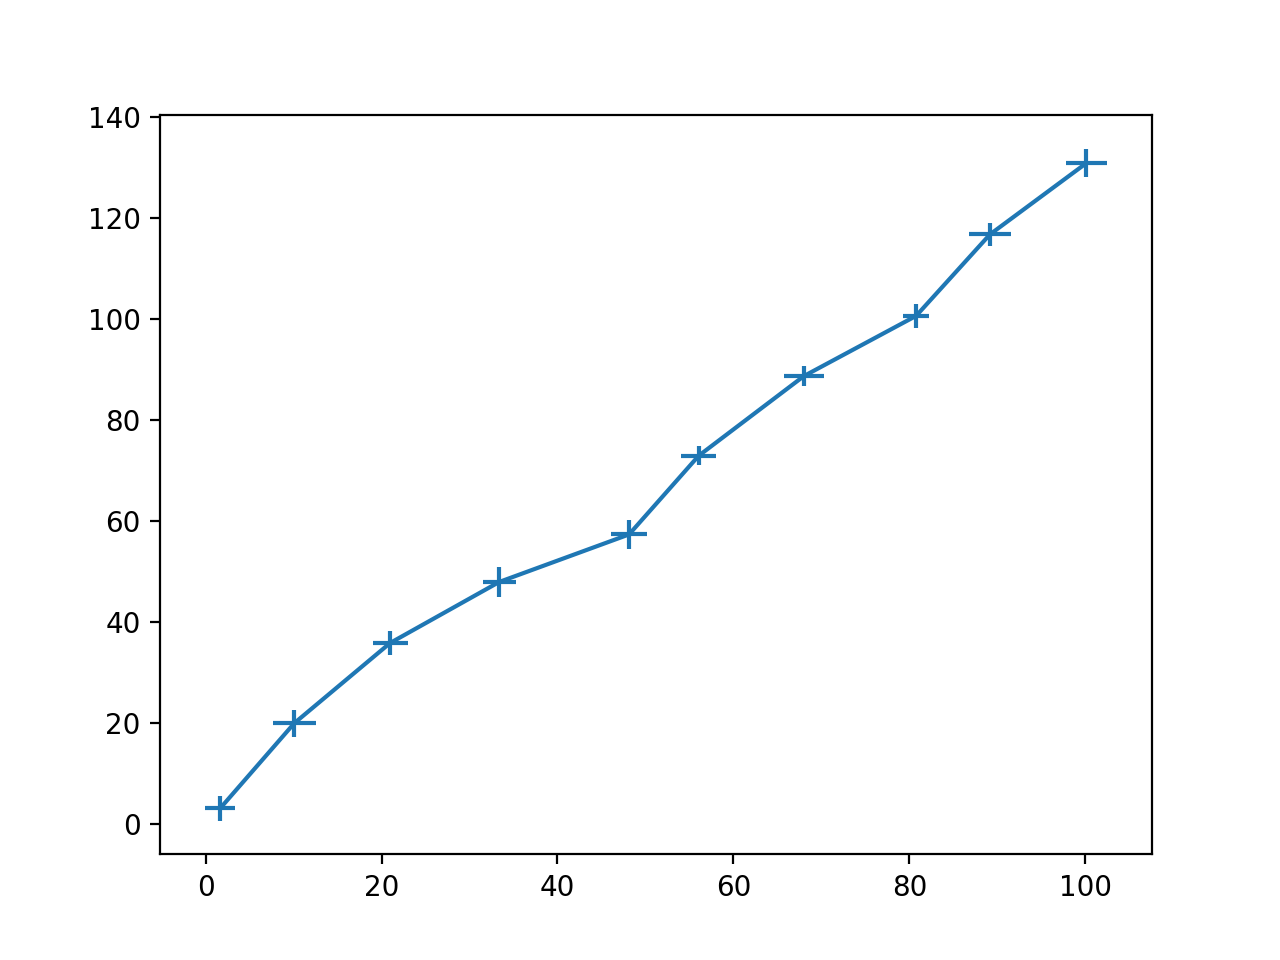

<Container object of 3 artists>

In [369]:
figure()
errorbar(xdata,ydata,xerr=xerr,yerr=yerr)

In [370]:
a,b,erra,errb,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),10000)

print a
print erra

print b
print errb

BCES, 10000 trials... 
1.330539 s
[ 1.23487071  1.23257976  1.23372125  1.23347526]
[ 0.03948358  0.03860395  0.0389527   0.03874812]
[ 4.52302102  4.65196589  4.58768493  4.60149236]
[ 2.6217649   2.60967672  2.6121751   2.60557192]


In [383]:
bces.bces?